# Trading Earnings Volatility

## Background

Quarterly earning announcements can cause potentially extreme moves in individual equities as companies under/over perform relative to expectation. These are previously announced events with known times, giving both day traders and large institutions the opportunity to place volatility and directional bets in the options marketplace, capitalizing on market reaction and the sentiment to the report.

To highlight this, we can look at the recent underlying volatility surrounding AMZN and GOOG earnings at the start of 2022, with Alphabet reporting after the market close on 2/1 and AMZN reporting after the market close on 2/2.

GOOG rallied from 2757 to 2960, a gain of 7.3% between the earnings report and the close on 2/2. (GOOGL very similar performance)
Amazon dropped from 3012 to 2776, losing more than 8% between the earnings report and the close on 2/3.

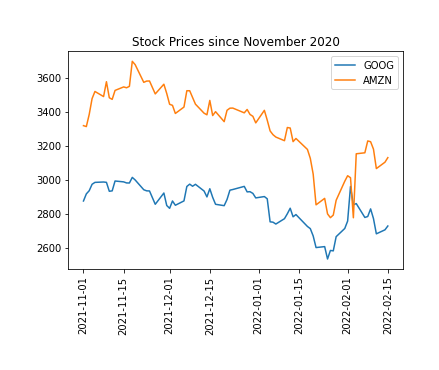

In [1]:
from IPython.display import Image
Image('GOOG_AMZN.png')

## Hypothesis

Stocks experience higher than average realized volatility around quarterly earnings announcements.


The average realized volatility of an individual equity stock through its historical earnings reports relative to its baseline performance is predictive of how much we would expect it to move on an upcoming earnings press release.


If the shortest dated at the money options for an issuer is priced on an implied volatility higher than our prediction for realized volatility going into an earnings, there is a positive expected value in selling the at the money straddle. If the straddle is priced below our prediction for realized volatility, there is a positive expected value position in buying the straddle. 


## Data

We will be using the WRDS OptionsMetrics database to get our data. Specifically, 'OptionMetrics - Historical Volatility' and 'OptionMetrics - Option Prices'.

### Required:
1. Historical earnings dates
2. Daily realized volatility calculations
3. Daily option implied volatilities
4. Daily market close bid/ask prices for the nearest term 50d call and put option

### May Want to Consider:
5. Daily option volumes
6. Earnings data vs expectations

## Strategy Execution

Select a subset of companies that we expect would be a good candidate for this volatility trading strategy. We will select stocks with liquid options markets with earnings announcements that have sparked increased options trading speculation. We also need to select companies that have enough of an earnings history to form a prediction.

For each stock selected:
    1. Compare realized volatility on and the day after earnings announcements to their average realized volatility in the training data set
    2. Calculate an expectation for realized volatility for the future earnings dates in a testing data set and compare it to the implied volatility of the at the money straddle in the day's preceeding the earnings dates.
    3. Construct a sizing curve depending on the difference between implied volatility vs expected realized volatility. Depending on the difference, trade up to 10k notional buying or selling the at the money straddle at the close price BBO.
    4. Close out our straddle position T+1 after earnings date.
    


## Analysis and Data

In [145]:
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import statsmodels.api as sm
quandl.ApiConfig.api_key = 'bULWv51MebBBGL56KGys'
import warnings
warnings.filterwarnings('ignore')


#### Select historical adjusted close prices for companies with liquid options markets

In [3]:
#Our option price data ends on 12/31/20 so we will end our analysis on that date.
start = '2015-01-01'
end = '2020-12-31'

tickers = ['GOOG', 'AMZN', 'SNAP', 'MSFT', 'FB', 'TSLA', 'NVDA', 'JPM', 'AVGO', 'VZ']

adj_close = quandl.get_table("QUOTEMEDIA/PRICES", 
                        ticker = tickers,  
                        qopts = { 'columns': ['ticker', 'date', 'adj_close']},  
                        date = { 'gte': start, 'lte': end}, 
                        paginate = True)

adj_close.head()

,ticker,date,adj_close
None,,,
0,VZ,2020-12-31,55.537089
1,VZ,2020-12-30,54.960449
2,VZ,2020-12-29,55.593808
3,VZ,2020-12-28,55.754511
4,VZ,2020-12-24,55.622167


#### 

### Financial statement filing date

In [4]:
# earnings dates (FC/FILING_DATE)
zacks_fc = quandl.get_table('ZACKS/FC', 
                    per_end_date = { 'gte': start, 'lte': end },
                    ticker = tickers, 
                    paginate=True)

In [5]:
# quarterly report filing dates
filing_dates = zacks_fc[zacks_fc['per_type'] == 'Q'][['ticker', 'filing_date']]
filing_dates

,ticker,filing_date
None,,
6,AMZN,2015-04-24
7,AMZN,2015-07-24
8,AMZN,2015-10-23
9,AMZN,2016-01-29
10,AMZN,2016-04-29
...,...,...
292,VZ,2020-02-21
293,VZ,2020-04-27
294,VZ,2020-07-28


#### Historical option data

In [6]:
# this is limited to options with expiry less than 15 days from current date.
option_data = pd.read_csv('data/OptionMetrics.csv.gz', sep = ',')

In [7]:
# match date format of quandl data
option_data['date'] = option_data.apply(lambda row: row.date.replace('/', '-', 2), axis = 1)
option_data['exdate'] = option_data.apply(lambda row: row.exdate.replace('/', '-', 2), axis = 1)

In [8]:
# strike_price = strike * 1000
option_data.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,optionid,ticker,index_flag,issuer,exercise_style
0,2015-01-02,2015-01-09,C,235000,71.90,75.55,0,0.919228,0.986198,106179177,AMZN,0,AMAZON.COM INC.,A
1,2015-01-02,2015-01-09,C,240000,67.00,70.85,0,0.955372,0.975301,106179178,AMZN,0,AMAZON.COM INC.,A
2,2015-01-02,2015-01-09,C,245000,61.85,65.35,0,0.695843,0.992689,106134398,AMZN,0,AMAZON.COM INC.,A
3,2015-01-02,2015-01-09,C,250000,57.15,60.45,0,0.771536,0.978447,106134399,AMZN,0,AMAZON.COM INC.,A
4,2015-01-02,2015-01-09,C,255000,52.00,55.45,0,0.673865,0.981649,106134400,AMZN,0,AMAZON.COM INC.,A


### Analysis

In [95]:
class Earnings_strat():
    
    def __init__(self, filing_dates_df, option_data_df, adj_close_df, vola_window):
        self.filing_dates_df = filing_dates_df
        self.option_data_df = option_data_df
        self.adj_close_df = adj_close_df
        self.vola_window = vola_window
        self.data_cleaned = False
        
    def __calc_rolling_vola(self):
        
        close_vola_df = pd.DataFrame()
        
        for t in self.adj_close_df.ticker.unique():
            df = self.adj_close_df[self.adj_close_df['ticker'] == t]
            df = (df['adj_close'].rolling(self.vola_window).std() * np.sqrt(252)) / df['adj_close']
            close_vola_df = pd.concat([close_vola_df, df], axis = 0)
            
        close_vola_df=close_vola_df.rename(columns={0:"vola_{}day".format(self.vola_window)})
        close_vola_df = pd.concat([self.adj_close_df, close_vola_df], axis = 1)
        
        return close_vola_df
    
    # this function returns the 50 delta calls and puts for exdate immediately after filing_date
    def __filter_opts(self):
                
        self.opt_expiry = {}
        result = pd.DataFrame(columns = ['ticker', 'filing_date', 'exdate'])
        
        # find option expiring after earnings date
        for s in self.option_data_df['ticker'].unique():
        
            filing = pd.DataFrame(self.filing_dates_df[self.filing_dates_df['ticker'] == s])
            options = pd.DataFrame(self.option_data_df[self.option_data_df['ticker'] == s])
    
            options['exdate'] = pd.to_datetime(options['exdate'])
            filing['filing_date'] = pd.to_datetime(filing['filing_date'])
        
            # want options that expire after filing date
            filing['filing_date'] = filing['filing_date'] + pd.Timedelta('1 days')
        
            filing_exdate = []
        
            for d in filing['filing_date']:
                try:
                    date = options[options['exdate'] > d].head(1).exdate.item()
                    
                    result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
                                          ignore_index = True)
                except ValueError: # error raised if no option expiry after final filing date
                    continue

        result['filing_date'] = pd.to_datetime(result['filing_date'])
        result['exdate'] = pd.to_datetime(result['exdate'])
        self.filing_dates_df = pd.DataFrame(result)
        
        self.option_data_df['exdate'] = pd.to_datetime(self.option_data_df['exdate'])
        
        # merge on exdate just after filing_dates
        self.option_data_df = pd.merge(self.option_data_df, self.filing_dates_df,
                                       on = ['ticker', 'exdate'])
        
        # get options closest to delta=50 for each expiry
        res = pd.DataFrame()
        for s in self.option_data_df['ticker'].unique():
            
            call_d, put_d = {}, {}
            
            df = self.option_data_df[self.option_data_df['ticker'] == s]
        
            df = df.set_index('date')
        
            for d in df.index.unique():
                call_i = (abs(df.loc[d]['delta'] - 0.5)).argmin()
                put_i = (abs(df.loc[d]['delta'] + 0.5)).argmin()
                call_d[d] = df.loc[d].iloc[call_i]
                put_d[d] = df.loc[d].iloc[put_i]
            
            calls = pd.DataFrame(call_d).transpose()
            puts = pd.DataFrame(put_d).transpose()
        
            calls.index = pd.to_datetime(calls.index)
            puts.index = pd.to_datetime(puts.index)
            
            temp = pd.concat([calls, puts], axis = 0)
            res = pd.concat([res, temp], axis = 0)
        
        return res
    
    # clean_data returns the daily 50 delta call and put for each symbol
    # and includes the next filing_date, adj_close, and rolling realized vol
    def clean_data(self):
        close_vola_df = self.__calc_rolling_vola()
        cleaned_opts = self.__filter_opts()
        
        cleaned_opts = cleaned_opts.reset_index()
        cleaned_opts = cleaned_opts.rename(columns = {'index':'date'})
        
        self.atm_opts = pd.merge(cleaned_opts, close_vola_df, on=['date', 'ticker'])
        
        self.data_cleaned = True
        return self.atm_opts
    
    def __is_weekend(self, day):
    
        if (day.weekday() == 6):
            return day + pd.Timedelta(days = 1)
        elif (day.weekday() == 5):
            return day + pd.Timedelta(days = 2)
        else:
            return day
        
    def __is_expiry(self, expiry, exit_date):
        if (exit_date == expiry):
            return (exit_date - pd.Timedelta('1 days'))
        else:
            return exit_date
    
    # returns df with bid/ask 'days' days before earnings and 1 day after earnings
    # as well as implied and realized vol 'days' days before earnings
    # so we can use this df to find a correlation between the two
    def vol_vs_straddle(self, days):
        
        if (not self.data_cleaned):
            print("must run clean_data function first")
            return
        
        opts = pd.DataFrame(self.atm_opts)
        
        opts['days_to_filing'] = opts['filing_date'] - opts['date']
        opts['filing_day_of_week'] = opts['filing_date'].dt.weekday
        opts = opts[opts['days_to_filing'] == '{} days'.format(days)]
        opts['day_after_filing'] = opts['filing_date'] + pd.Timedelta(days=1)
        
        opts = opts.rename(columns = {'date': 'today', 'day_after_filing': 'date'})
        opts['adj_date'] = opts.apply(lambda row: self.__is_weekend(row['date']), axis = 1)
        
        opt_prices = pd.DataFrame(self.option_data_df[['date', 'optionid', 'best_bid',
                                                       'best_offer', 'volume']])
        opt_prices = opt_prices.rename(columns = {'best_bid': 'post_bid', 
                                                  'best_offer': 'post_offer'
                                                 ,'volume': 'post_volume'})
        opts = opts.drop(['date'], axis=1)
        opts = opts.rename(columns={'adj_date':'date'})
        opts['date'] = pd.to_datetime(opts['date'])
        opt_prices['date'] = pd.to_datetime(opt_prices['date'])
        
        # NOTE: here I make the assumption that companies whose options expire the day after
        # the earnings report announce earnings before the open. so if data doesn't look great,
        # comment these lines and try again (you'll have less data)
        opts['adj_date'] = opts.apply(lambda row: self.__is_expiry(row.exdate, row.date), axis = 1)
        opts = opts.drop(['date'], axis=1)
        opts = opts.rename(columns={'adj_date':'date'})

        #---------------------------------------------------------------

        o = pd.merge(opts, opt_prices, on = ['optionid', 'date'])
        
        agg_f = {'exdate': 'first', 'strike_price': 'first', 'best_bid': 'sum', 'best_offer': 'sum',
        'volume': 'mean', 'impl_volatility': 'mean', 'filing_date': 'first', 'adj_close': 'first',
        'post_bid': 'sum', 'post_offer': 'sum', 
        'post_volume': 'mean', 'vola_{}day'.format(self.vola_window): 'mean', 'date':'first'}
        
        out = o.groupby(['today', 'ticker']).aggregate(agg_f)
        out['volatility_edge'] = out['impl_volatility'] - out['vola_{}day'.format(self.vola_window)]
        
        out = out.rename(columns={'date': 'date_after_filing'})
        
        return out
        
    
    

In [63]:
# there are 224 filing dates
# filing_dates[filing_dates['exdate'] != 0]

In [99]:
strat = Earnings_strat(filing_dates, option_data, adj_close, vola_window = 7)

In [100]:
opts = strat.clean_data()

In [101]:
vol_straddle = strat.vol_vs_straddle(1)

In [232]:
# post_bid and post_offer and post_volume are data 1 day after earnings
# everything else is n days before earnings
# analyze vol_diff vs. change in bid/offer
def DisplayCorrelations(test_set):
    print('\n Correlations between the spread between implied and realized volatility and change in straddle price \n')

    for tickerName in test_set['ticker'].unique():
        df = test_set[test_set['ticker'] == tickerName]

        model = sm.OLS(df['volatility_edge'], df['straddle_change'])
        results = model.fit()

        plt.scatter(df['volatility_edge'], df['straddle_change'], label = tickerName)
        print('{}: Correlation {:.4f}, Beta {:.4f}'.format(tickerName, df['volatility_edge'].corr(df['straddle_change']), results.params[0]))

    print('Overall Strategy correlation: {:.4f}'.format(test_set['volatility_edge'].corr(test_set['straddle_change'])))
    model = sm.OLS(test_set['volatility_edge'], test_set['straddle_change'])
    results = model.fit()
    print('Overall Beta: {:.5f}'.format(results.params[0]))
    plt.title('Vol Edge and Straddle Change Correlations')
    plt.legend(loc="upper center", bbox_to_anchor=(1.25, 1.15), ncol=1)
    plt.show()

def Backtest(df):
    df['shortPnL'] = 0
    df['longPnL'] = 0
    for index, row in df.iterrows():
        ### implied exceeds realized, we sell the straddle
        if row['volatility_edge'] > 0:
            df.at[index, 'shortPnL'] += -1 * df.at[index, 'straddle_change'] * 100  
        else:
            ##realized exceeds implied, we buy the straddle
            df.at[index, 'longPnL'] += df.at[index, 'straddle_change'] * 100  

    table = pd.DataFrame()
    for tickerName in df['ticker'].unique():
            sub = df[df['ticker'] == tickerName]
            table = table.append({'ticker': tickerName, 'Long PnL': sub['longPnL'].sum(), 'Short PnL': sub['shortPnL'].sum(), 'Total PnL': sub['longPnL'].sum() + sub['shortPnL'].sum()}, ignore_index = True)

    display(table.set_index('ticker').sort_values('Total PnL', ascending=False))

    print('PnL from shorts: {:.2f}'.format(df['shortPnL'].sum()))
    print('PnL from longs {:.2f}'.format(df['longPnL'].sum()))

In [164]:
vol_straddle['initial_straddle_price'] = vol_straddle['best_bid'] + vol_straddle['best_offer']
vol_straddle['final_straddle_price']  = vol_straddle['post_bid'] + vol_straddle['post_offer']
vol_straddle['straddle_change'] = vol_straddle['final_straddle_price'] - vol_straddle['initial_straddle_price']

# Paramterizing Trading Strategy

#### Understanding the Volatility Edge Spreads

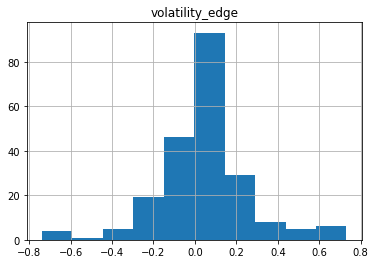

Average Vol Spread 0.0438
Standard Deviation Vol Spread 0.2154


In [173]:
vol_straddle.hist('volatility_edge')
plt.show()
print('Average Vol Spread {:.4f}'.format(vol_straddle['volatility_edge'].mean()))
print('Standard Deviation Vol Spread {:.4f}'.format(vol_straddle['volatility_edge'].std()))

Looking at a historical distribution of the implied - realized vol spread, the average implied volatility is priced at a premium to realized volatility; implied volatility takes into account very rare events and the potentail for extreme downside moves and compensates the seller for this addiitional risk. Using this distribution we will use an average vol spread of .04 instead of assume that on average implied is priced at the current realized volatility level. There is significant standard deviation in our data as well. The shape of this distribution can help 
inform how we size. 

Breaking down our testing data set, we can look at some sample stats to decide how we want to paramaterize our trading algorithm. The first decision points we can focus on are: which stocks should we trade and how much volatility edge should we demand in either direction to make a trade. To make a decision on the stocks in our portfolio, we calculate the correlation between the volatility edge and the change in straddle price across earnings. What we are looking for is stocks with big negative correlation values. An option with an implied vol priced high above its realized volatility means there is a big straddle down fit after the event. An option priced on an implied volatility lower than its realized leads to a big straddle up fit. Those stocks that don't exhibit such correlations we will drop from consideration.

The benefit to limiting our test to specific stocks/volatility edge values is it should reduce variance in our strategy performance and reduce tracking error from our expected PnLs. The downside is it lowers the total number of profit making opportunities we have.



#### Selecting Stocks


 Potential Portfolio

 Correlations between the spread between implied and realized volatility and change in straddle price 

AVGO: Correlation -0.5094, Beta -0.0125
NVDA: Correlation -0.0341, Beta -0.0036
FB: Correlation -0.8856, Beta -0.0473
MSFT: Correlation -0.9183, Beta -0.0450
AMZN: Correlation -0.0451, Beta -0.0012
VZ: Correlation -0.6250, Beta -0.0375
GOOG: Correlation -0.3904, Beta -0.0013
JPM: Correlation 0.1019, Beta 0.0330
TSLA: Correlation -0.3638, Beta -0.0364
SNAP: Correlation -0.5273, Beta -0.0937
Overall Strategy correlation: -0.2641
Overall Beta: -0.00776


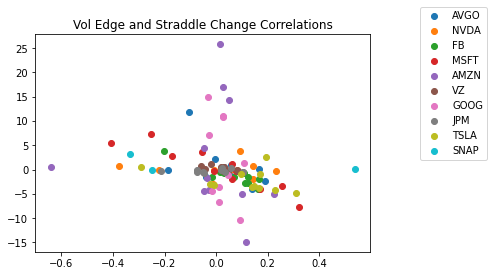


 JPM, AMZN, NVDA all did not show strong correlations. 
 Does not seem like we will be successful trading these tickers in an event volatility strategy so we can discard them.

 Final Portfolio:

 Correlations between the spread between implied and realized volatility and change in straddle price 

AVGO: Correlation -0.5094, Beta -0.0125
FB: Correlation -0.8856, Beta -0.0473
MSFT: Correlation -0.9183, Beta -0.0450
VZ: Correlation -0.6250, Beta -0.0375
GOOG: Correlation -0.3904, Beta -0.0013
TSLA: Correlation -0.3638, Beta -0.0364
SNAP: Correlation -0.5273, Beta -0.0937
Overall Strategy correlation: -0.4402
Overall Beta: -0.01570


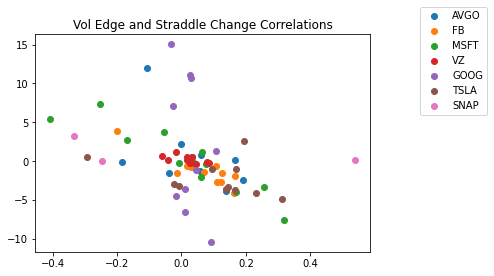

In [233]:

training = vol_straddle.reset_index()[:100]
print('\n Potential Portfolio')
DisplayCorrelations(training)

print('\n JPM, AMZN, NVDA all did not show strong correlations. \n Does not seem like we will be successful trading these tickers in an event volatility strategy so we can discard them.')
print('\n Final Portfolio:')
training_sub = training[~training['ticker'].isin(['AMZN', 'JPM', 'NVDA'])]
DisplayCorrelations(training_sub)

## Setting Edge Spacer

Below a certain abs edge threshold, the edge won't be sufficient enough to cover the risk of the trade. It also doesn't have a very strong correlation with the preceeding straddle fit. Experimenting with different minimum trading widths, it looks like demanding at least 5 vol points of edge from the mean removes a decent number of trades that had very low correlation of .0049 and betas close to 0 (26 trade instances) while the remaining 42 trades shown after now have a correlation of -0.51 and a beta of -.02. We will sample a few different minimum trading widths in our backtest but I think ~5 vol points is a decent place to start.

### Below Min Width


 Correlations between the spread between implied and realized volatility and change in straddle price 

VZ: Correlation -0.4974, Beta -0.0406
MSFT: Correlation -0.0569, Beta -0.0154
TSLA: Correlation nan, Beta 0.0025
GOOG: Correlation 0.3764, Beta 0.0015
FB: Correlation -0.9977, Beta -0.0443
AVGO: Correlation -0.7712, Beta -0.0019
Overall Strategy correlation: 0.0049
Overall Beta: 0.00060


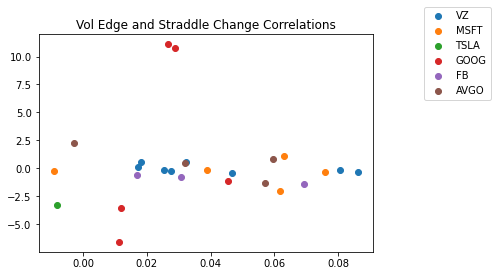

Total obersevations: 68
Total trades inside spacer: 26


In [235]:
testing_sub = training[~training['ticker'].isin(['AMZN', 'JPM', 'NVDA'])]
testing_sub_inside = training_sub[abs(training_sub['volatility_edge'] - training_sub['volatility_edge'].mean()) < .05]
DisplayCorrelations(testing_sub_inside)
print('Total obersevations: {}'.format(training_sub.shape[0]))
print('Total trades inside spacer: {}'.format(testing_sub_inside.shape[0]))

#### Above Min Width


 Correlations between the spread between implied and realized volatility and change in straddle price 

AVGO: Correlation -0.5027, Beta -0.0130
FB: Correlation -0.8831, Beta -0.0475
MSFT: Correlation -0.9335, Beta -0.0459
GOOG: Correlation -0.5845, Beta -0.0034
TSLA: Correlation -0.4122, Beta -0.0406
VZ: Correlation 0.5847, Beta -0.0360
SNAP: Correlation -0.5273, Beta -0.0937
Overall Strategy correlation: -0.5146
Overall Beta: -0.02140


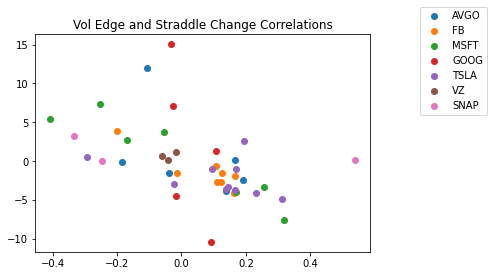

Total obersevations: 68
Total trades outside spacer: 42


In [236]:
testing_sub = training[~training['ticker'].isin(['AMZN', 'JPM', 'NVDA'])]
training_sub_inside = training_sub[abs(training_sub['volatility_edge'] - training_sub['volatility_edge'].mean()) > .05]
DisplayCorrelations(training_sub_inside)
print('Total obersevations: {}'.format(training_sub.shape[0]))
print('Total trades outside spacer: {}'.format(training_sub_inside.shape[0]))

In [237]:
Backtest(training_sub_inside)

,Long PnL,Short PnL,Total PnL
ticker,,,
MSFT,1925.0,1495.0,3420.0
GOOG,1763.0,904.0,2667.0
AVGO,1036.0,615.0,1651.0
TSLA,-244.0,1895.0,1651.0
FB,227.0,1360.0,1587.0
SNAP,316.0,-17.0,299.0
VZ,198.0,0.0,198.0


PnL from shorts: 6252.00
PnL from longs 5221.00


In [240]:
testing = vol_straddle.reset_index()[100:]
testing_sub = testing[~testing['ticker'].isin(['AMZN', 'JPM', 'NVDA'])]
testing_sub_inside = testing_sub[abs(testing_sub['volatility_edge'] - testing_sub['volatility_edge'].mean()) > .05]

In [242]:
Backtest(testing_sub_inside)

,Long PnL,Short PnL,Total PnL
ticker,,,
GOOG,14330.0,2994.0,17324.0
TSLA,2864.0,11761.0,14625.0
AVGO,7894.0,544.0,8438.0
MSFT,1679.0,3016.0,4695.0
FB,38.0,713.0,751.0
SNAP,124.0,115.0,239.0
VZ,122.0,49.0,171.0


PnL from shorts: 19192.00
PnL from longs 27051.00
